In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
import matplotlib
import matplotlib as mpl
import re
import geopandas

import dask
import os
import sys
sys.path.insert(0, '/net/fs11/d0/emfreese/BC-IRF/')
import utils
import plotting_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
countries = ['MALAYSIA','CAMBODIA','INDONESIA','VIETNAM']

## Add time dimension
days_per_year = 365

length_simulation = utils.years*days_per_year
time_array = np.arange(0, length_simulation)
shutdown_years = np.arange(2000,2061,1)

In [3]:
###### Import prepared plant data #######
CGP_df = pd.read_csv(f'{utils.data_output_path}plants/BC_SE_Asia_all_financing_SEA_GAINS_Springer_plus_rad.csv', index_col = [0])
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})
min_year = CGP_df['Year_of_Commission'].min()

##remove any plants that have no data on commission year
CGP_df = CGP_df.loc[CGP_df['Year_of_Commission'].dropna().index]
print('Emis data prepped and loaded')


######## Country mask and dataframe ######

country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50
country_df = geopandas.read_file(f'{utils.raw_data_in_path}/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
impacted_countries = ['China','Australia', 'India','Myanmar',  'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan','Brunei', 'Papua New Guinea', 'Solomon Islands', 'East Timor', 'Taiwan']
country_df = country_df.rename(columns = {'SOVEREIGNT':'country'})

ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/stretch_2x_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);


Emis data prepped and loaded


/tmp/ipykernel_2774208/435376560.py:15: UserWarning: `land_50` of `natural_earth_v4_1_0` and `natural_earth_v5_0_0` does not quite extend to 90°S - it's recommended to use `natural_earth_v5_1_2` instead. See https://github.com/regionmask/regionmask/issues/487
  country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_50


In [4]:
#convert from g/day to g/yr

CGP_df['BC_(g/yr)'] = CGP_df['BC_(g/day)'] * days_per_year #g/year
CGP_df.drop(columns = ['BC_(g/day)', 'BC_(kg/m2/year)'], inplace = True)

In [5]:
ARTP = pd.read_csv(f'{utils.data_output_path}/ARTP_processed.csv')
#take mean across winter and summer, assuming each season is 50% of the forcing
ARTP = ARTP.groupby(['Location','t_horizon',]).mean('Emis_season')

In [6]:
# Multiply the ARTP by the emissions
lhs  = pd.DataFrame(CGP_df['BC_(g/yr)'])
ARTP.index = ['{}_{}'.format(i, j) for i, j in ARTP.index]
rhs = pd.DataFrame(ARTP.transpose())
empty_df = pd.DataFrame(data = None, index = lhs.index, columns = rhs.columns).fillna(1)
k_em = empty_df*rhs.loc['BC_K_ug']
em_yr = (empty_df.transpose()* lhs.transpose().loc['BC_(g/yr)']).transpose()
k_g = k_em*em_yr * 1e6 #convert units from ug to g

/tmp/ipykernel_2774208/2224827201.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  empty_df = pd.DataFrame(data = None, index = lhs.index, columns = rhs.columns).fillna(1)


In [7]:
# Function to extract number from column name
def get_number_from_column(col_name):
    match = re.search(r'_(\d+)$', col_name)  
    if match:
        return int(match.group(1))
    return None


# Iterate through columns and divide by number if found
for col in k_g.columns:
    number = get_number_from_column(col)
    if number is not None:
        k_g[col] = k_g[col] / number

In [8]:
CGP_df = pd.concat([CGP_df, k_g], axis = 1)

#add in the radiative forcing by location (need to get citation)
Tg_per_ug = 1e18
rad_force_dict = {'MALAYSIA': 1.32e-2/Tg_per_g, 'INDONESIA':1.17e-2/Tg_per_g, 'VIETNAM':1.30e-2/Tg_per_g, 'CAMBODIA':1.81e-2/Tg_per_g} #units = W/m2/Tg  BC

for c in rad_force_dict.keys():
    CGP_df.loc[CGP_df['COUNTRY'] == c,'rad_forcing_wperm2perkg'] = rad_force_dict[c]

In [9]:
#calculate the years of operation, emissions for that amount of time, and radiative forcing over that time for all plants (if they are running for up to 40 years or less)
E_CO2_all_opts = {}

#for each early shutdown year
for yr in shutdown_years:
    #calculate the years until shutdown for each plant
    E_CO2_all_opts[yr] = ((yr- CGP_df.loc[(CGP_df['BC_(g/yr)'] >0)]['Year_of_Commission'] ))
    #make datasets
    E_CO2_all_opts[yr] = xr.DataArray(data = E_CO2_all_opts[yr].values,
                                dims = ['unique_ID'],
                                coords = dict(unique_ID = 
                                              CGP_df.loc[(CGP_df['BC_(g/yr)'] >0)].index),
                                attrs = dict(description = 'years that each power plant operates under a given early shutdown',
                                            units = 'yrs'))
    

    #make sure the plants are operating, and that they don't exceed their lifetime (estimated 40 years)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] > 0).fillna(0)
    E_CO2_all_opts[yr] = E_CO2_all_opts[yr].where(E_CO2_all_opts[yr] <= 40).fillna(40)

#concatenate into a dataset
shutdown_ds= xr.concat([E_CO2_all_opts[m] for m in E_CO2_all_opts.keys()], pd.Index([m for m in E_CO2_all_opts.keys()], name='closure_year'), join = 'outer')


In [10]:
country_id_ds = CGP_df.loc[CGP_df['BC_(g/yr)'] >0].groupby('unique_ID').first().to_xarray() #[['COUNTRY','unique_ID','CO2_weighted_capacity_1000tonsperMW', 'ANNUALCO2', 'MW',
                                                      #'CON.COUNTRY', 'PAR.COUNTRY', 'AE.COUNTRY','Year_of_Commission', 'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf']]

In [11]:
#make a dataset of the max lifetime possible
max_shutdown_ds = xr.ones_like(shutdown_ds)*40

In [12]:
ug_to_ng = 1e3

for c in countries:
    for unique_id in CGP_df.loc[(CGP_df['COUNTRY'] == c) & (CGP_df['BC_(g/yr)'] >0)]['unique_ID'].values:
        print(c, unique_id)

In [13]:
######### import the convolutions ###############
conv_df = {}
for c in countries:
    for unique_id in CGP_df.loc[(CGP_df['COUNTRY'] == c) & (CGP_df['BC_(g/yr)'] >0)]['unique_ID'].values:
        path = f'{utils.data_output_path}convolution/convolution_{c}_{unique_id}_uniqueid.nc'
        if os.path.exists(path):
            conv_df[unique_id] = pd.read_csv(path, index_col = 0)
            conv_df[unique_id] = conv_df[unique_id].to_xarray().rename({'index':'country_impacted'})
        else:
            print(f'missing {c} {unique_id}')


In [14]:
conv_ds = xr.concat([conv_df[t] for t in conv_df.keys()], pd.Index([t for t in conv_df.keys()], name='unique_ID'), join = 'outer')#*ug_to_ng

In [15]:
shutdown_ds.name = 'plants_shutdown'
max_shutdown_ds.name = 'remaining_plants'

shutdown_ds.attrs['units'] = 'none'
max_shutdown_ds.attrs['units'] = 'none'

In [16]:

def is_string_dtype(dtype):
    return dtype.kind in {'U', 'S', 'O', 'i'}

# Select non-string variables
non_string_vars = {var: country_id_ds[var] for var in country_id_ds.data_vars 
                   if not is_string_dtype(country_id_ds[var].dtype)}

In [17]:
reduced_id_ds = country_id_ds[non_string_vars.keys()].rename({'ANNUALCO2':'co2_emissions', 'MW':'MW_total',  'snowrf_toa':'snowrf', 'drf_toa':'drf', 'dt_snowrf':'dt_snowrf','dt_drf':'dt_drf'})

In [18]:
var_drop_list = ['Unnamed:_0', 'UNITID', 'UNIT', 'PLANT', 'COMPANY', 'MW', 
                 'STATUS', 'Year_of_Commission', 'UTYPE', 'FUEL', 'FUELTYPE', 
                 'ALTFUEL', 'SSSMFR', 'BOILTYPE', 'TURBMFR', 'TURBTYPE', 'GENMFR', 
                 'GENTYPE', 'SFLOW', 'SPRESS', 'STYPE', 'STEMP', 'REHEAT1', 'REHEAT2', 
                 'PARTCTL', 'PART.BAT', 'PARTMFR', 'SO2CTL', 'SO2.BAT', 'FGDMFR', 'NOXCTL', 'NOX.BAT', 
                 'NOXMFR', 'AE', 'AE.COUNTRY', 'AE.CHINA', 'CONSTRUCT', 'CON.COUNTRY', 'CON.CHINA', 'COOL', 
                 'RETIRE', 'CITY', 'STATE', 'AREA', 'SUBREGION', 'POSTCODE', 'PARENT', 'PAR.COUNTRY', 
                 'PAR.CHINA', 'ELECTYPE', 'BUSTYPE', 'COMPID', 'LOCATIONID', 'HEATRATE.UNADJ', 
                 'CO2_weighted_capacity_1000tonsperMW', 'CAPFACTOR', 'ANNUALCO2', 'EMISFACTOR.GCPT', 
                 'HEATRATE.ADJ', 'COAL', 'EMISFACTOR.CO2', 'HEATRATE', 'EMISFACTOR.BC.GAINS', 
                 'EMISFACTOR.BC.GAINS.g_mwh', 'MWh_daily', 'location_key', 'latitude', 'longitude', 
                 'grid_area_m2']

In [19]:
#multiple the timeline datasets and convolutions by the emissions/radiation datasets
vars_ds = shutdown_ds*reduced_id_ds
vars_max_ds = max_shutdown_ds*reduced_id_ds

conv_shutdown_ds = conv_ds * shutdown_ds
conv_max_ds = conv_ds * max_shutdown_ds

# drop the variables that are not needed if they are in the var_ds or vars_max_ds
var_ds_drop = [var for var in var_drop_list if var in vars_ds.data_vars]
vars_ds = vars_ds.drop(var_ds_drop)
vars_max_ds_drop = [var for var in var_drop_list if var in vars_max_ds.data_vars]
vars_max_ds = vars_max_ds.drop(vars_max_ds_drop)

/tmp/ipykernel_2774208/3975099822.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vars_ds = vars_ds.drop(var_ds_drop)
/tmp/ipykernel_2774208/3975099822.py:12: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  vars_max_ds = vars_max_ds.drop(vars_max_ds_drop)


In [20]:
# Create the new dimension with labels
scenario_dim = pd.Index(['main', 'max'], name='scenario')

# Concatenate the datasets along the new dimension
vars_combined_ds = xr.concat([vars_ds, vars_max_ds], dim=scenario_dim)
# Concatenate the datasets along the new dimension
conv_combined_ds = xr.concat([conv_shutdown_ds, conv_max_ds], dim=scenario_dim)

rad_force_ds = country_id_ds['rad_forcing_wperm2perkg']*Emis_ds

k_per_tg_per_yr = 0.04 #https://acp-copernicus-org.libproxy.mit.edu/articles/20/3079/2020/ Sand et al.
temp_ds = Emis_ds/Tg_per_kg

conv_dsrad_force_ds.name = 'BC_forcing'
rad_force_ds.attrs = {'units':'W/m2'}

temp_ds.name = 'BC_temp'
temp_ds.attrs = {'units':'K'} 

In [21]:
# Create a merged dataset
full_ds = xr.merge([country_id_ds.drop(['ANNUALCO2',  'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'BC_(g/yr)',
                                                'Global_10',
                                                'Global_20',
                                                'Global_50',
                                                'Global_100',
                                                'N_arctic_10',
                                                'N_arctic_20',
                                                'N_arctic_50',
                                                'N_arctic_100',
                                                'N_midlat_10',
                                                'N_midlat_20',
                                                'N_midlat_50',
                                                'N_midlat_100',
                                                'S_subtropics_10',
                                                'S_subtropics_20',
                                                'S_subtropics_50',
                                                'S_subtropics_100',
                                                'Tropics_10',
                                                'Tropics_20',
                                                'Tropics_50',
                                                'Tropics_100']), 
                    vars_combined_ds, 
                    conv_combined_ds]).rename({'COUNTRY':'country_emitting'})


/tmp/ipykernel_2774208/397238800.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  full_ds = xr.merge([country_id_ds.drop(['ANNUALCO2',  'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'BC_(g/yr)',


# Plotting

#convert to ng/m3 (from ng/m3/yr) for our mean values
delta_t = full_ds['closure_year'].max().values - min_year
for val in ['BC_surface_mean_conc', 'max_BC_surface_mean_conc', 'BC_pop_weight_mean_conc', 'max_BC_pop_weight_mean_conc', 'BC_column_mean_conc', 'max_BC_column_mean_conc', 'MW_total', 'max_MW_total']:
    full_ds[val]*=delta_t
    full_ds[val].attrs = {'units':'ng/m3'}

### Maps

In [22]:
gdf = country_df[country_df['country'].isin(impacted_countries)][['country','geometry']].rename(columns = {'country':'country_impacted'}).set_index('country_impacted')

In [23]:
map_locations = ['MALAYSIA', 'CAMBODIA', 'INDONESIA', 'VIETNAM', 'all']
shutdown_years = np.arange(2030, 2060, 10)

# Without normalization
regular_data = plotting_utils.prepare_concentration_data(
    full_ds, gdf,
    map_locations, 
    shutdown_years
)

# With normalization
normalized_data = plotting_utils.prepare_concentration_data(
    full_ds, gdf,
    map_locations, 
    shutdown_years,
    normalize=True,
    emissions_df=CGP_df  # Pass your emissions dataframe
)


In [ ]:

# # Plot regular data
# fig1, axes1 = plotting_utils.plot_concentration_maps(
#     regular_data, 
#     map_locations, 
#     shutdown_years,
#     variable='BC_pop_weight_mean_conc'
# )

# Plot normalized data
fig2, axes2 = plotting_utils.plot_concentration_maps(
    normalized_data, 
    map_locations, 
    shutdown_years,
    impacted_countries,
    country_df,
    variable='BC_pop_weight_mean_conc',
    vmin=1e-15,  
    vmax=1e-10,
    save_path = '../figures/BC_concentration_maps_normalized.png'
)


In [43]:
import cmocean

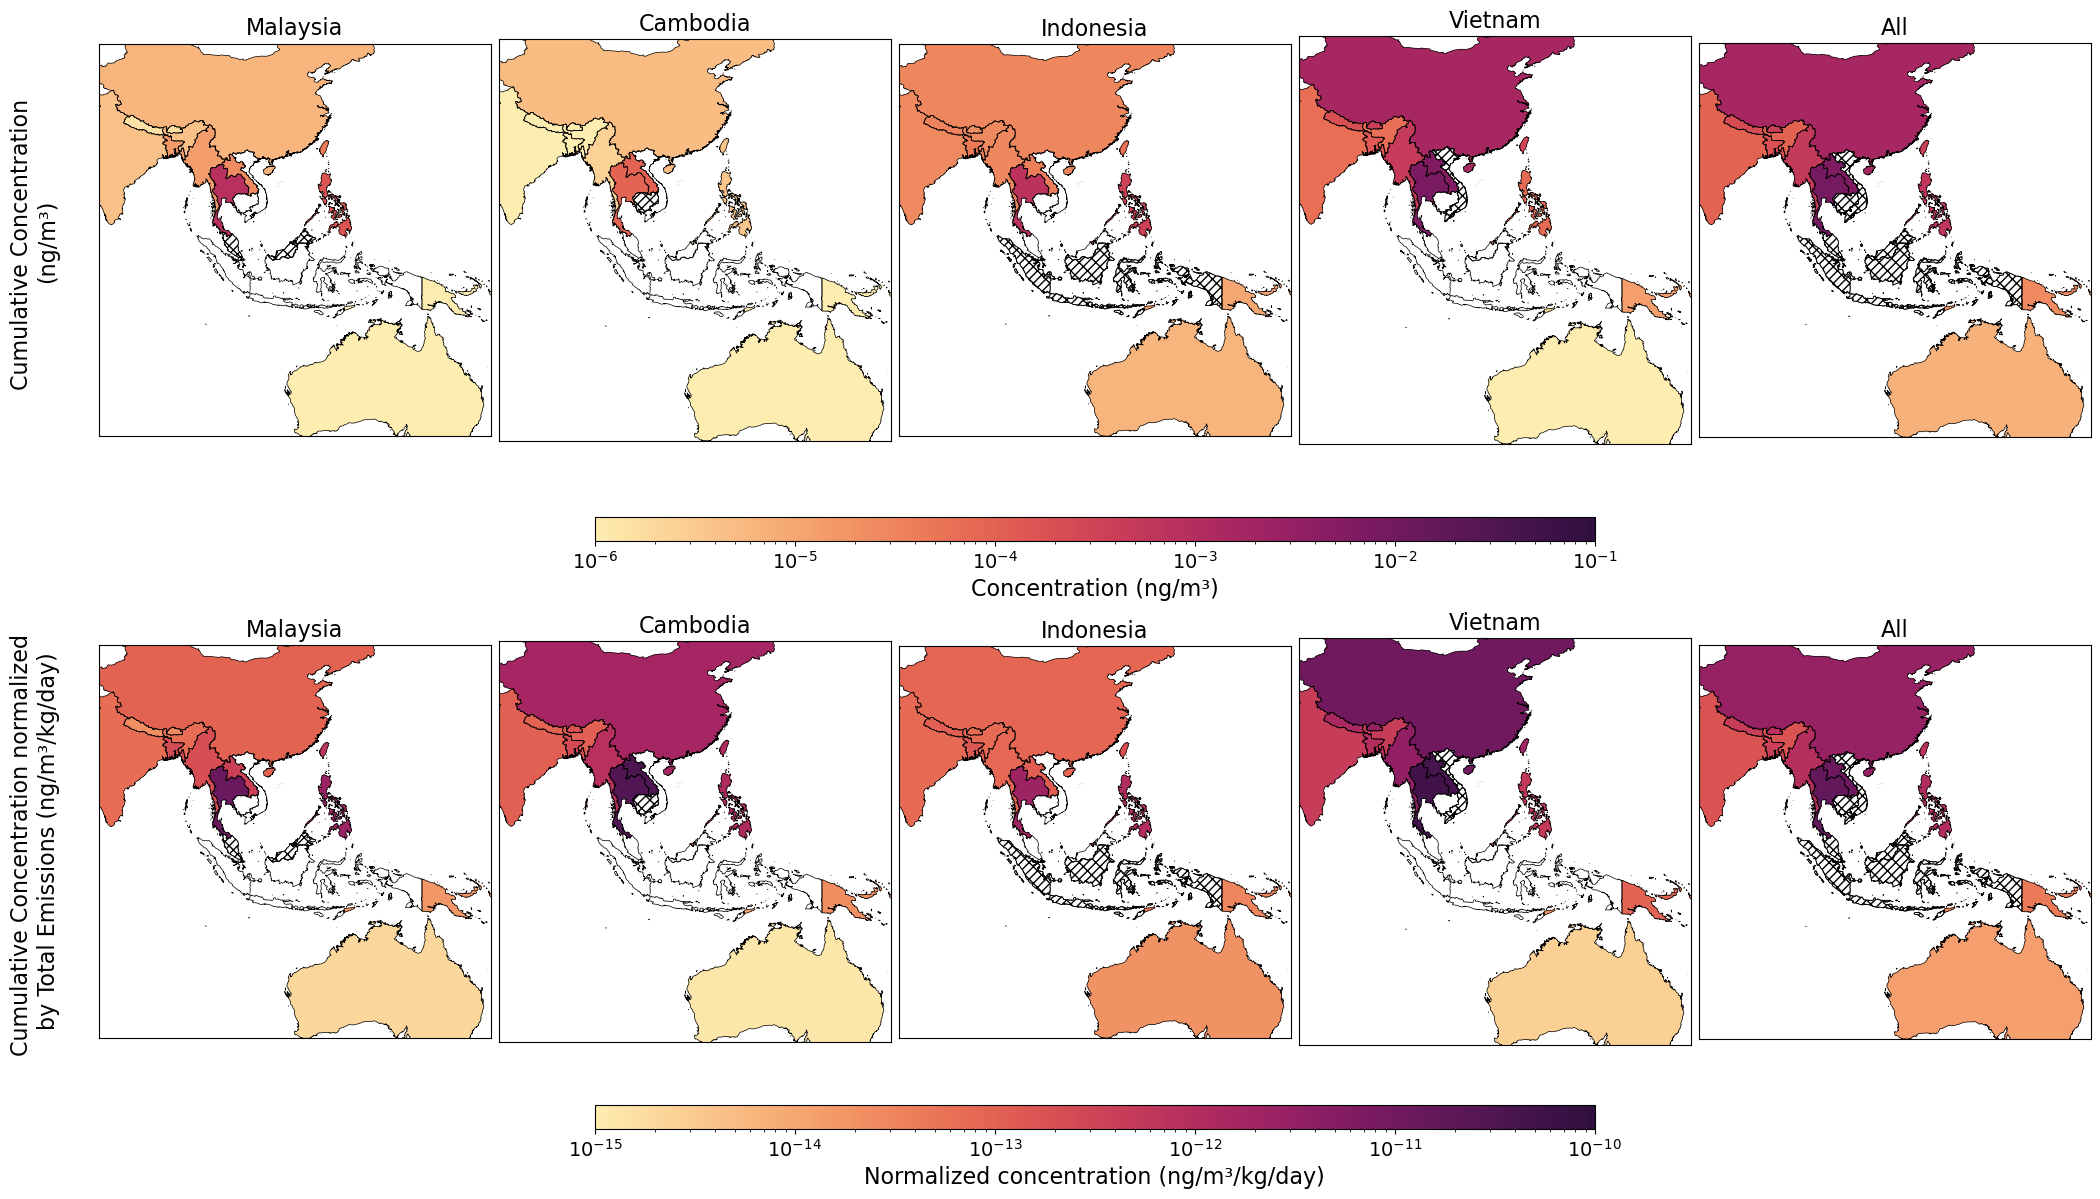

In [47]:
yr = 2040
plotting_utils.plot_single_year_concentration_maps(
    regular_data,
    normalized_data, 
    map_locations, 
    yr,
    impacted_countries,
    country_df,
    variable='BC_pop_weight_mean_conc',
    vmin_regular=1e-6, vmax_regular=1e-1,
    vmin_norm=1e-15,  
    vmax_norm=1e-10,
    save_path = f'../figures/paper/BC_concentration_maps_normalized_regular_{yr}.png'
);

## Testing new plots

In [64]:
def plot_strategy_comparison(age_ds, mw_ds, emis_intens_ds, 
                           country='China', year=2040, 
                           target_co2_reduction=0.5,
                           variable='BC_pop_weight_mean_conc'):
    """
    Create a more intuitive comparison of different plant retirement strategies.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Extract data for the specified year and country
    year_age = age_ds[variable].sel(scenario='main', country_impacted=country, 
                                    closure_year=year)
    year_mw = mw_ds[variable].sel(scenario='main', country_impacted=country,
                                 closure_year=year)
    year_emis = emis_intens_ds[variable].sel(scenario='main', country_impacted=country,
                                           closure_year=year)
    
    co2_age = age_ds['co2_emissions'].sel(scenario='main', closure_year=year)
    co2_mw = mw_ds['co2_emissions'].sel(scenario='main', closure_year=year)
    co2_emis = emis_intens_ds['co2_emissions'].sel(scenario='main', closure_year=year)
    
    # Find the point where each strategy reaches target CO2 reduction
    target_co2 = co2_age.max() * (1 - target_co2_reduction)
    
    # Interpolate to find BC reduction at that CO2 target
    age_result = np.interp(target_co2, co2_age, year_age)
    mw_result = np.interp(target_co2, co2_mw, year_mw)  
    emis_result = np.interp(target_co2, co2_emis, year_emis)
    
    # Plot as a bar chart
    strategies = ['Oldest First', 'Largest First', 'Most Polluting First']
    values = [age_result, mw_result, emis_result]
    
    bars = ax.bar(strategies, values, color=['skyblue', 'lightgreen', 'salmon'])
    
    # Normalize to best strategy for percentage comparison
    best = min(values)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        pct_diff = ((height - best) / best) * 100
        if pct_diff > 0:  # Only add text for non-optimal strategies
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01*max(values),
                   f'+{pct_diff:.1f}%', ha='center', fontweight='bold')
    
    ax.set_ylabel(f'BC Concentration Reduction (ng/m³)', fontsize=12)
    ax.set_title(f'Comparison of Plant Retirement Strategies\n'
                f'Target: {target_co2_reduction*100}% CO2 Reduction by {year}', fontsize=14)
    
    plt.tight_layout()
    return fig, ax

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Comparison of Plant Retirement Strategies\nTarget: 50.0% CO2 Reduction by 2040'}, ylabel='BC Concentration Reduction (ng/m³)'>)

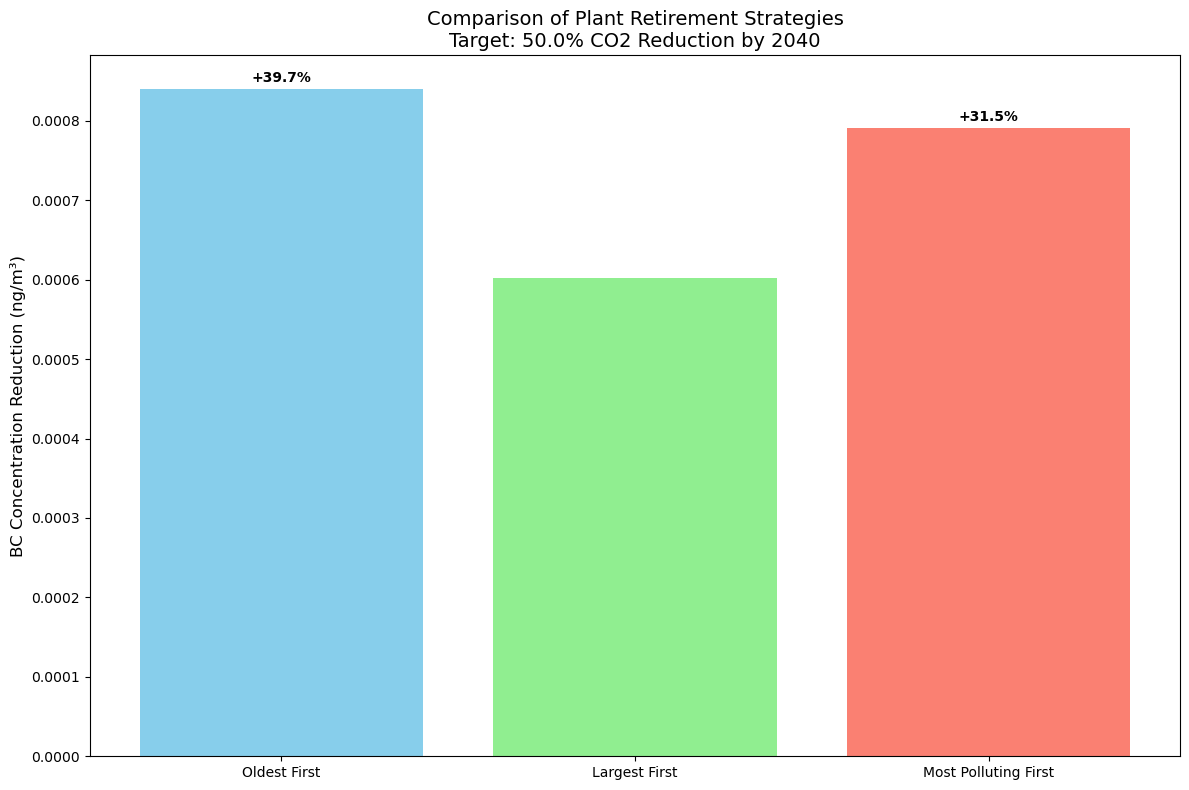

In [65]:
plot_strategy_comparison(age_ds, mw_ds, emis_intens_ds, 
                           country='China', year=2040, 
                           target_co2_reduction=0.5,
                           variable='BC_pop_weight_mean_conc')

In [ ]:
def plot_timeline_impacts(cumulative_impacts, country='China'):
    """Create a timeline showing emissions and impacts over time."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Extract data
    years = cumulative_impacts.year.values
    co2 = cumulative_impacts['co2_emissions'].sum(dim='unique_ID')
    bc = cumulative_impacts['BC_(g/yr)'].sum(dim='unique_ID')
    bc_conc = cumulative_impacts['BC_pop_weight_mean_conc'].sel(country_impacted=country).sum(dim='unique_ID')
    
    # Plot emissions
    ax1.plot(years, co2/1e9, 'k-', linewidth=2)
    ax1.set_ylabel('Cumulative CO₂\nEmissions (Gt)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot BC emissions
    ax2.plot(years, bc/1e12, 'b-', linewidth=2) 
    ax2.set_ylabel('Cumulative Black Carbon\nEmissions (kt)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Plot BC concentration
    ax3.plot(years, bc_conc, 'r-', linewidth=2)
    ax3.set_ylabel(f'BC Concentration\nin {country} (ng/m³)', fontsize=12)
    ax3.set_xlabel('Year', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(f'Cumulative Impacts from Southeast Asian Coal Plants\nEffects on {country}', 
                fontsize=16)
    plt.tight_layout()
    return fig

plot_timeline_impacts(cumulative_impacts, country='China')

## Sankey Diagram

In [36]:
# Create a Sankey diagram for all sources in 2040
fig = plotting_utils.create_sankey_from_map_data(regular_data, normalized_data, year=2040, location='all', top_n = 5)
fig.write_image("../figures/paper/sankey_diagram_2040.png", scale=2)  # scale=2 for higher resolution

fig.show()

### Contours by shutdown choice

In [48]:
# Calculate cumulative emissions by plant age
age_ds, bckg_age_ds = plotting_utils.analyze_emissions_by_var(full_ds, 'Year_of_Commission')
# Calculate cumulative emissions by plant size
mw_ds, bckg_mw_ds = plotting_utils.analyze_emissions_by_var(full_ds, 'MW')
# Calculate cumulative emissions by plant emissions
emis_intens_ds, bckg_emis_intens_ds = plotting_utils.analyze_emissions_by_var(full_ds, 'CO2_weighted_capacity_1000tonsperMW')


#### Cumulative

In [49]:
def analyze_emissions_by_var_cumulative(full_ds, var, country=None):
    """
    Analyze cumulative emissions by progressively including plants sorted by a variable
    and cumulatively summing across years.
    
    Parameters:
    -----------
    full_ds : xarray.Dataset
        Dataset containing power plant data with 'unique_ID' and sorting variable
    var : str
        Variable to sort plants by (e.g., 'Year_of_Commission', 'MW')
    country : str, optional
        Filter to only include plants from this country
    
    Returns:
    --------
    cumulative_age_ds : xarray.Dataset
        Cumulative emissions from plants commissioned up to each threshold, 
        with cumulative summation over closure years
    cumulative_bckg_age_ds : xarray.Dataset
        Cumulative emissions from plants commissioned after each threshold,
        with cumulative summation over closure years
    """
    # Sort the dataset by the specified variable in descending order
    sorted_ds = full_ds.sortby(var, ascending=False)
    
    # Filter by country if specified
    if country:
        sorted_ds = sorted_ds.where(sorted_ds['country_emitting'] == country, drop=True)
    
    # Get the number of plants
    n_plants = len(sorted_ds['unique_ID'])
    
    # Initialize dictionaries to store results
    age_ds = {}
    bckg_age_ds = {}
    
    # Create datasets for each threshold
    for idx in range(1, n_plants + 1):
        # Sum emissions from plants up to idx
        age_ds[idx] = sorted_ds.isel(unique_ID=slice(0, idx)).sum(dim='unique_ID')
        # Sum emissions from remaining plants
        bckg_age_ds[idx] = sorted_ds.isel(unique_ID=slice(idx, n_plants)).sum(dim='unique_ID')

    # Concatenate along a new dimension representing the threshold
    age_ds = xr.concat([age_ds[i] for i in range(1, n_plants + 1)], 
                       pd.Index(range(1, n_plants + 1), name='plants_open'))
    
    bckg_age_ds = xr.concat([bckg_age_ds[i] for i in range(1, n_plants + 1)], 
                           pd.Index(range(1, n_plants + 1), name='plants_open'))
    
    # Now calculate the cumulative sum across closure years for each variable
    # Get the original variables (excluding coordinates)
    data_vars = [v for v in age_ds.data_vars]
    
    # Initialize DataArrays for cumulative results
    cumulative_age_ds = age_ds.copy()
    cumulative_bckg_age_ds = bckg_age_ds.copy()
    
    # Perform cumulative sum over closure_year dimension for each variable
    for var_name in data_vars:
        if 'closure_year' in age_ds[var_name].dims:
            # Sort by closure_year to ensure correct cumulative sum
            sorted_var = age_ds[var_name].sortby('closure_year')
            cumulative_age_ds[var_name] = sorted_var.cumsum(dim='closure_year')
            
            sorted_bckg_var = bckg_age_ds[var_name].sortby('closure_year')
            cumulative_bckg_age_ds[var_name] = sorted_bckg_var.cumsum(dim='closure_year')
    
    return cumulative_age_ds, cumulative_bckg_age_ds

In [50]:
cumulative_age_ds, cumulative_bckg_age_ds = analyze_emissions_by_var_cumulative(full_ds, 'Year_of_Commission', country=None)

#### Amount Each Year

In [51]:
empty_ds = xr.Dataset(
    coords={
        'country_impacted': conv_ds.country_impacted.values,
        'unique_ID': conv_ds.unique_ID.values,
        'year': np.arange(2000, 2061)
    }
)

df_reindexed = CGP_df.set_index('unique_ID')

plant_ranges = df_reindexed['Year_of_Commission'].apply(
    lambda year: np.arange(year, year + 40, 1) if not pd.isna(year) else None
)

df_reindexed['plant_time_range'] = plant_ranges

In [52]:
# Initialize a data variable filled with zeros
empty_ds['plant_active'] = xr.DataArray(
    np.zeros((len(empty_ds.country_impacted), len(empty_ds.unique_ID), len(empty_ds.year))),
    dims=['country_impacted', 'unique_ID', 'year']
)

# Fill with ones during operational years for each plant
for unique_id in empty_ds.unique_ID.values:
    # Get the plant's operation range
    if unique_id in df_reindexed.index:
        time_range = df_reindexed.loc[unique_id, 'plant_time_range']
        
        if time_range is not None:  # Skip plants with no time range
            # Find years that are in the time range
            valid_years = [y for y in empty_ds.year.values if y in time_range]
            
            if valid_years:
                # Create a boolean mask for this plant's active years
                year_mask = np.isin(empty_ds.year.values, valid_years)
                
                # Set value to 1 for all countries, this unique_ID, and active years
                empty_ds['plant_active'].loc[dict(unique_ID=unique_id, year=year_mask)] = 1

In [53]:
conv_plants_ds = empty_ds['plant_active']*conv_ds

id_plants_ds = reduced_id_ds * empty_ds['plant_active']

var_ds_drop = [var for var in var_drop_list if var in id_plants_ds.data_vars]
id_plants_ds = id_plants_ds.drop(var_ds_drop)



/tmp/ipykernel_2746243/643408145.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  id_plants_ds = id_plants_ds.drop(var_ds_drop)


In [54]:
full_ind_ds = xr.merge([country_id_ds.drop(['ANNUALCO2', 'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'BC_(g/yr)',
                                                'Global_10',
                                                'Global_20',
                                                'Global_50',
                                                'Global_100',
                                                'N_arctic_10',
                                                'N_arctic_20',
                                                'N_arctic_50',
                                                'N_arctic_100',
                                                'N_midlat_10',
                                                'N_midlat_20',
                                                'N_midlat_50',
                                                'N_midlat_100',
                                                'S_subtropics_10',
                                                'S_subtropics_20',
                                                'S_subtropics_50',
                                                'S_subtropics_100',
                                                'Tropics_10',
                                                'Tropics_20',
                                                'Tropics_50',
                                                'Tropics_100']), conv_plants_ds, id_plants_ds])

/tmp/ipykernel_2746243/1827346058.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  full_ind_ds = xr.merge([country_id_ds.drop(['ANNUALCO2', 'snowrf_toa', 'drf_toa', 'dt_snowrf','dt_drf','BC_(g/yr)', 'BC_(g/yr)',


In [55]:
var_age_ds, bckg_var_age_ds = plotting_utils.analyze_emissions_by_var(full_ind_ds, 'Year_of_Commission')
var_mw_ds, bckg_var_mw_ds = plotting_utils.analyze_emissions_by_var(full_ind_ds, 'MW')
var_emis_intens_ds, var_bckg_emis_intens_ds = plotting_utils.analyze_emissions_by_var(full_ind_ds, 'CO2_weighted_capacity_1000tonsperMW')


In [56]:
out = plotting_utils.plot_variable_by_country(var_mw_ds.sel(year = slice(2020, 2050)), 
                                        variable = var, 
                                        country = 'China',
                                        contour_variable= 'co2_emissions')

NameError: name 'var' is not defined

In [57]:
year_data = out.sel(year = 2040)

NameError: name 'out' is not defined

In [58]:
# Convert to numpy array for easier manipulation
year_values = year_data.values
plants_values = year_data.plants_open.values



NameError: name 'year_data' is not defined

### FIX THE MW AXIS

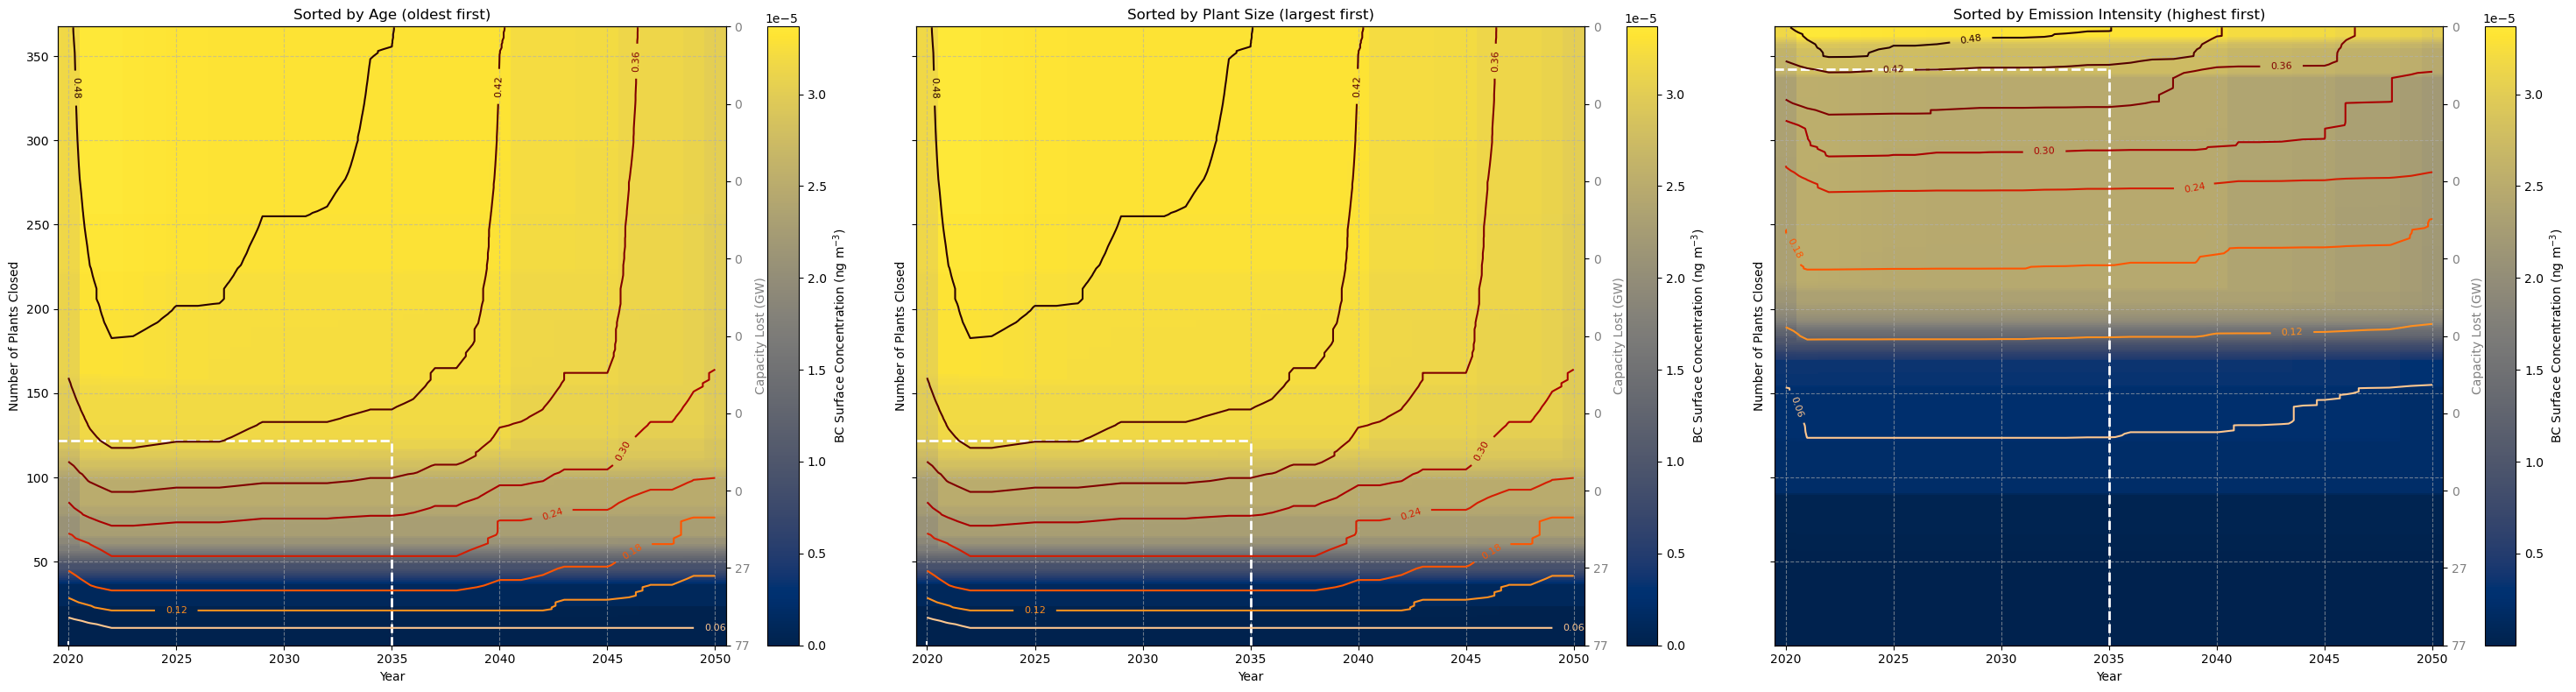

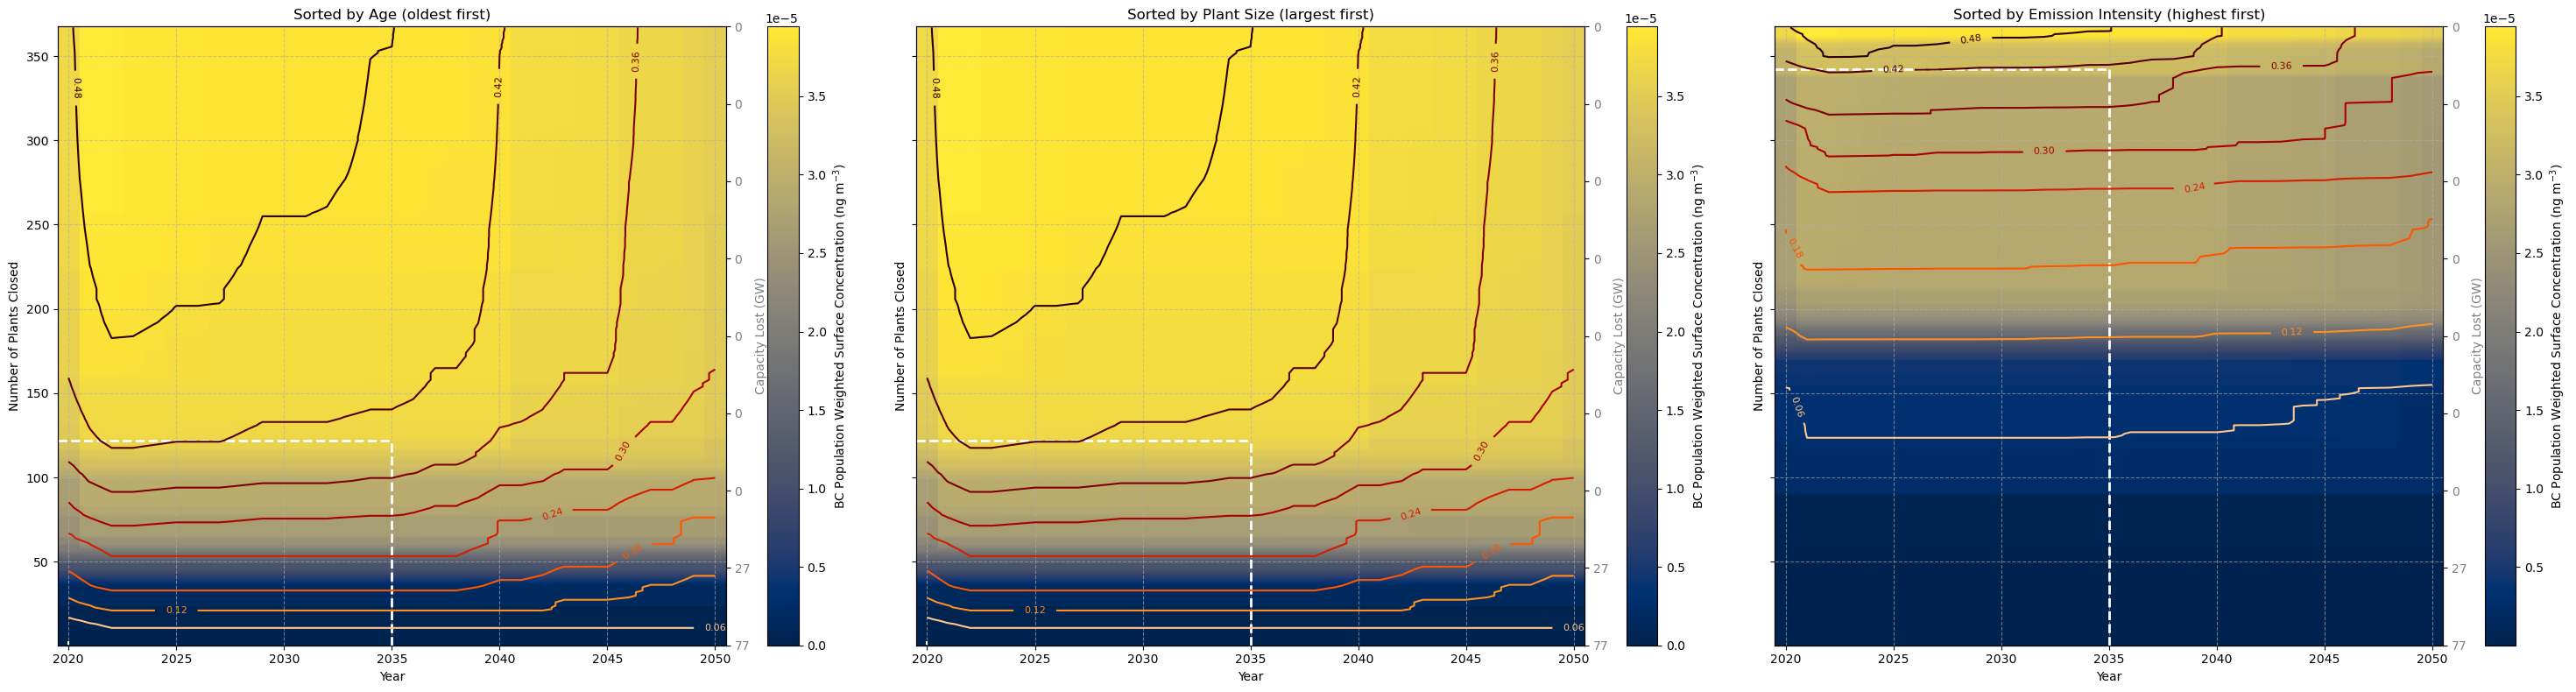

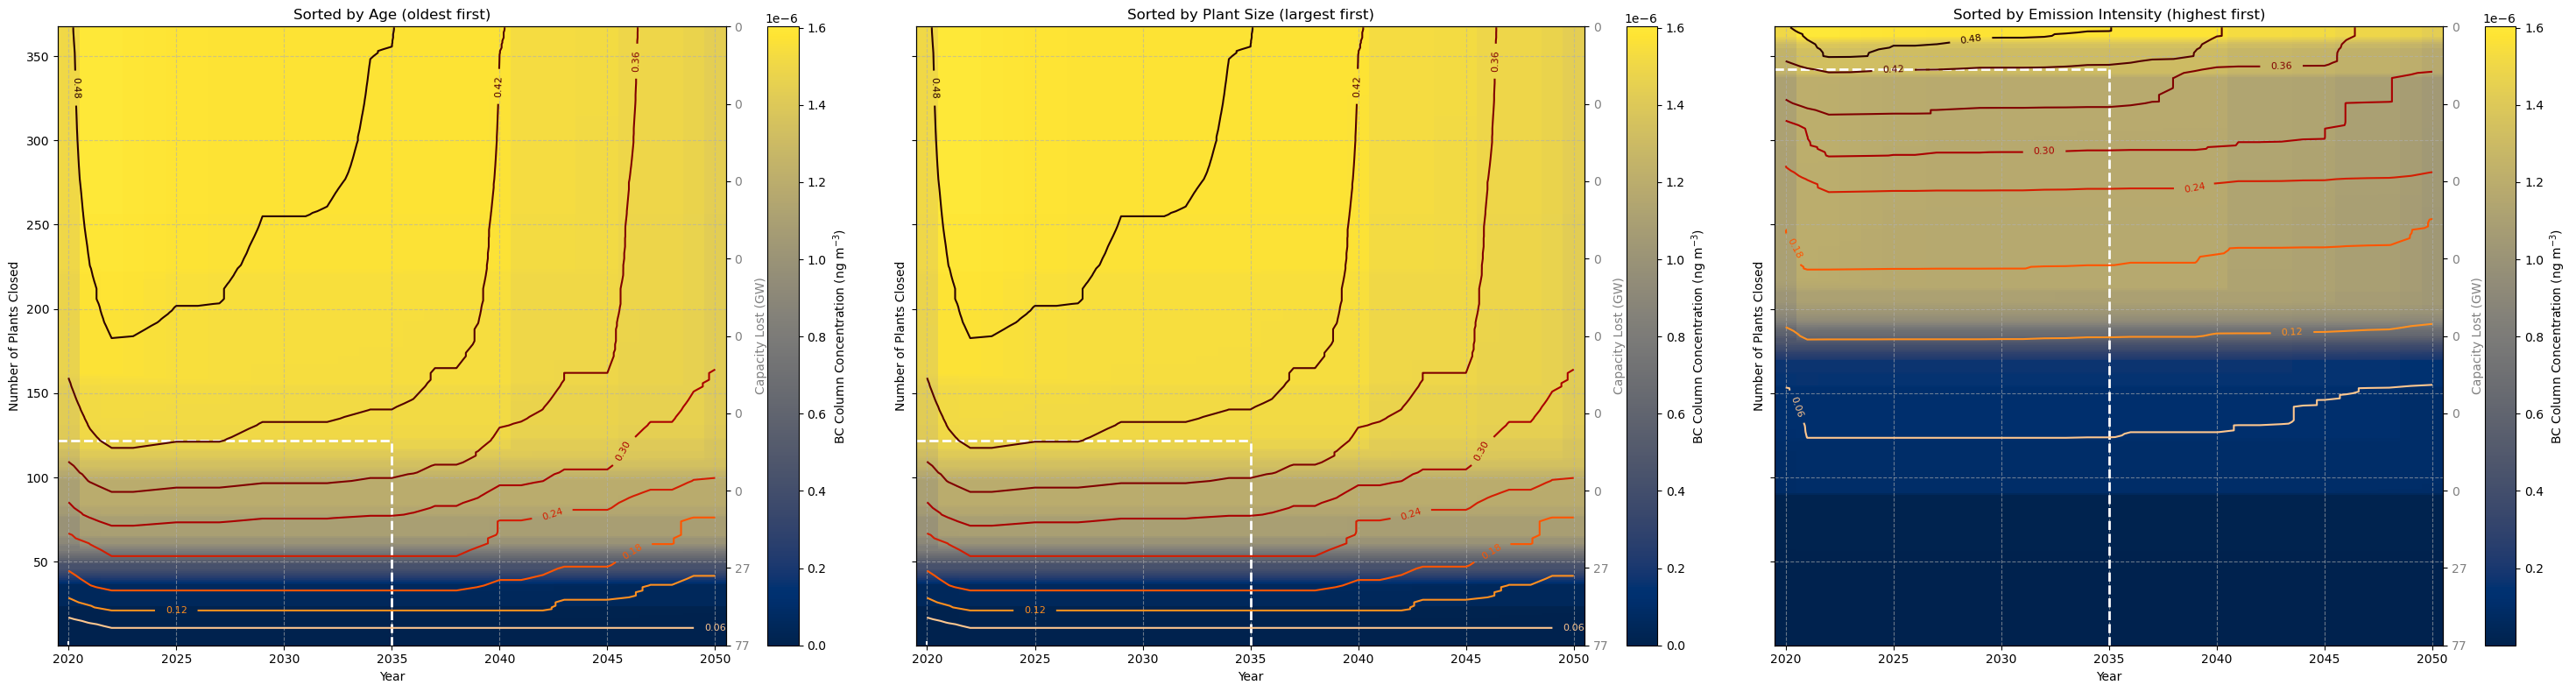

In [59]:
# Using default values (2040 and 10 GtCO2)

for var in ['BC_surface_mean_conc', 'BC_pop_weight_mean_conc', 'BC_column_mean_conc']:
    plotting_utils.plot_comparison(var_mw_ds.sel(year = slice(2020,2050)), 
                                   var_mw_ds.sel(year = slice(2020,2050)), 
                                   var_emis_intens_ds.sel(year = slice(2020,2050)), 
                                    variable=var,
                                    country='China',
                                    scenario='main',
                                    contour_variable='co2_emissions',
                                    levels=10,
                                    target_co2 = 0.4,
                                    target_year = 2035,
                                    flip_y_axis = True);
                        #plt.savefig('../figures/paper/contours_comparison_{var}.png', bbox_inches = 'tight', dpi = 300)


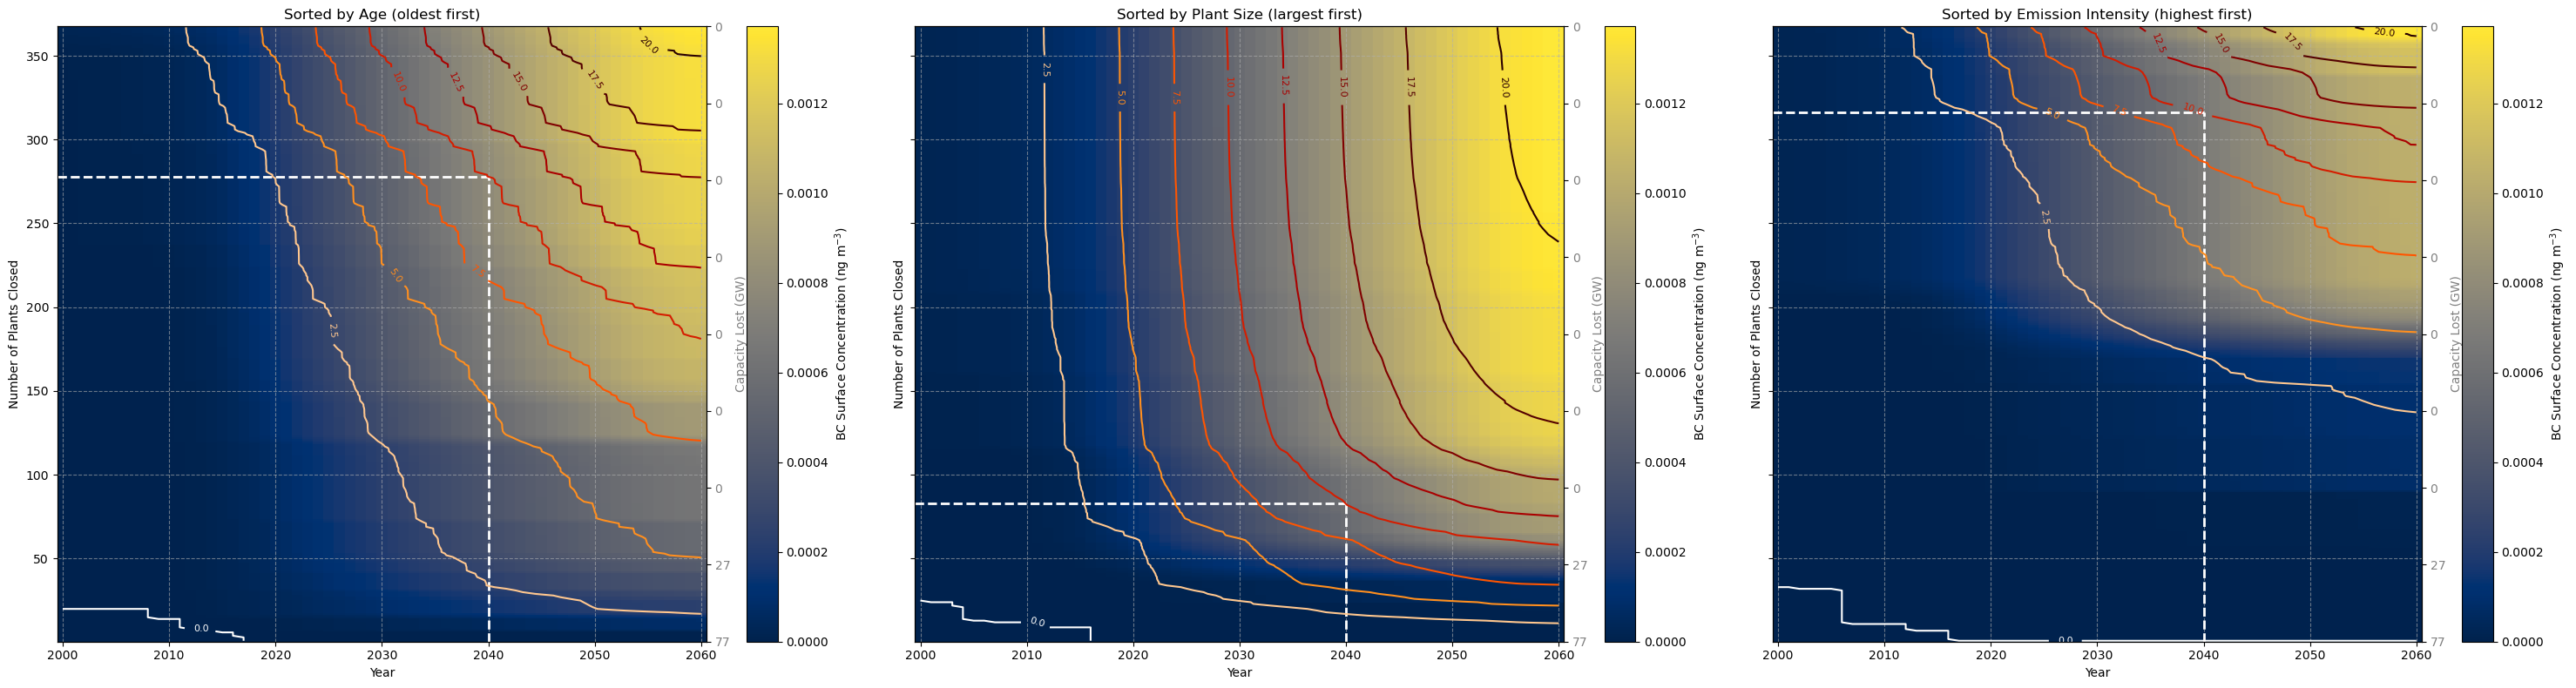

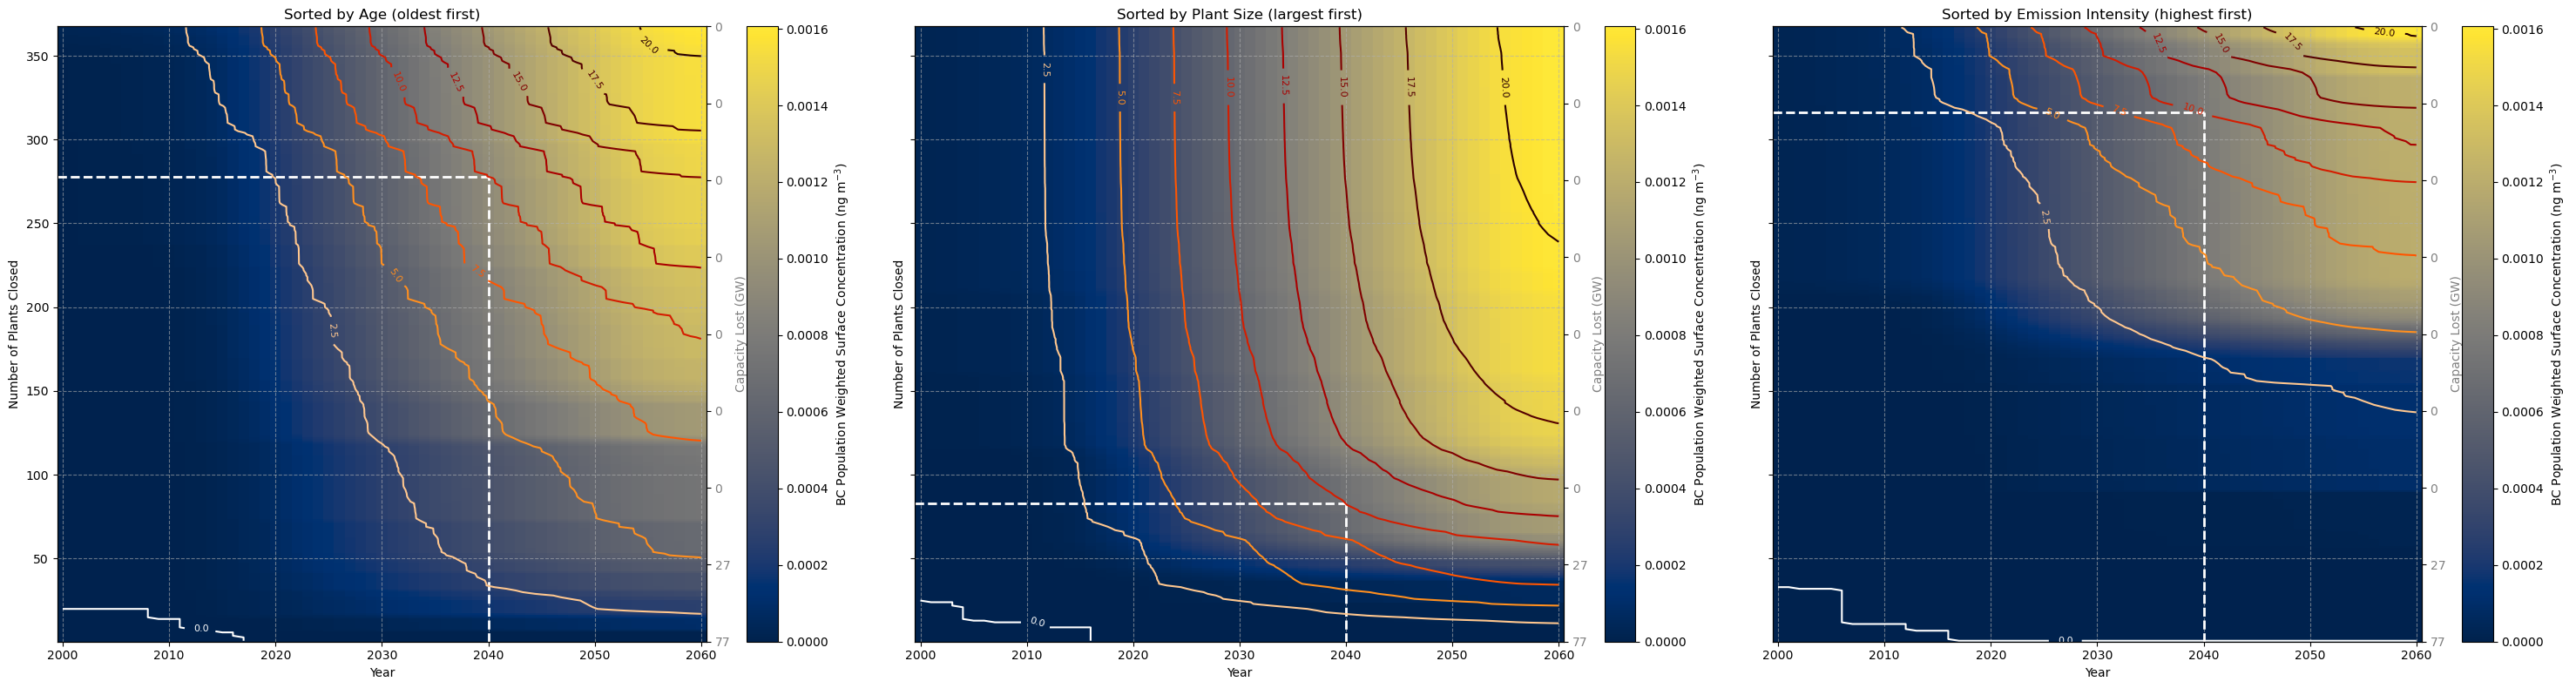

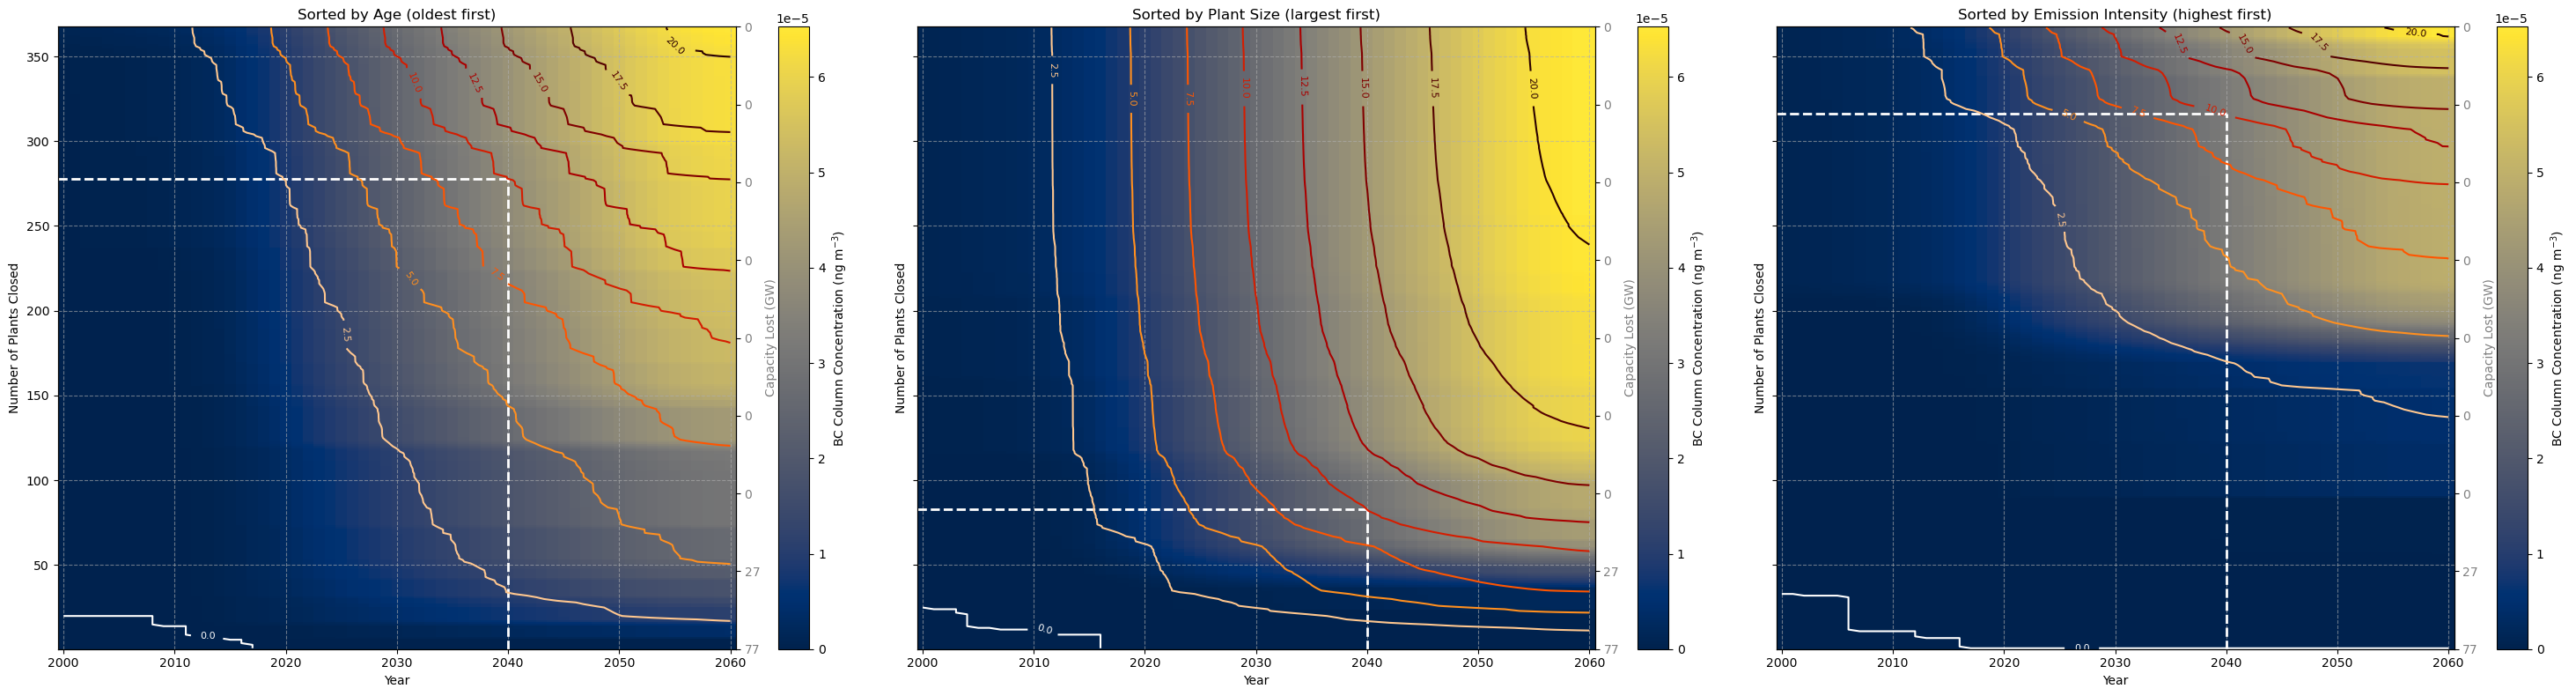

In [60]:
# Using default values (2040 and 10 GtCO2)

for var in ['BC_surface_mean_conc', 'BC_pop_weight_mean_conc', 'BC_column_mean_conc']:
    plotting_utils.plot_comparison(age_ds, mw_ds, emis_intens_ds, 
                variable=var,
                country='China',
                scenario='main',
                contour_variable='co2_emissions',
                levels=10);
    #plt.savefig('../figures/paper/contours_comparison_{var}.png', bbox_inches = 'tight', dpi = 300)


## Contours by Year of Pollution, Cumulative 

In [55]:
def analyze_emissions_over_time(CGP_df, conv_ds, start_year=2000, end_year=2060, max_lifetime=40):
    """
    Calculate emissions, pollution, and temperature impacts from operating plants
    for progressively longer periods (1 year, 2 years, etc.) from start_year to end_year.
    
    Parameters:
    -----------
    CGP_df : pandas.DataFrame
        DataFrame containing power plant data with emissions info
    conv_ds : xarray.Dataset
        Dataset with convolution data for calculating impacts
    start_year : int
        Starting year for analysis (default: 2000)
    end_year : int
        Ending year for analysis (default: 2060)
    max_lifetime : int
        Maximum lifetime of plants in years (default: 40)
    
    Returns:
    --------
    xarray.Dataset
        Dataset containing emissions, pollution, and temperature impacts by year and plant
    """
    # Filter plants with emissions
    active_plants = CGP_df.loc[CGP_df['BC_(g/yr)'] > 0]
    
    # Initialize dictionary to store results
    emissions_by_cumulative_years = {}
    
    # Number of years to analyze
    years_range = np.arange(1, end_year - start_year + 1)
    
    # For each cumulative year count (1 year, 2 years, etc.)
    for n_years in years_range:
        # Create operation years array for each plant
        operation_years = np.zeros(len(active_plants))
        
        for i, (idx, plant) in enumerate(active_plants.iterrows()):
            # Calculate commission year relative to start year
            commission_year = plant['Year_of_Commission']
            
            # Calculate how many years this plant operates within our n_years window
            if commission_year <= start_year + n_years - 1:
                # Plant was commissioned before or during the analysis period
                years_active = min(
                    n_years - max(0, start_year - commission_year),  # Years within our window
                    max_lifetime  # Cap at max lifetime
                )
                operation_years[i] = max(0, years_active)
            else:
                # Plant not yet commissioned in this time window
                operation_years[i] = 0
        
        # Create DataArray for this cumulative year count
        emissions_by_cumulative_years[n_years] = xr.DataArray(
            data=operation_years,
            dims=['unique_ID'],
            coords=dict(unique_ID=active_plants.index),
            attrs=dict(
                description=f'Years each plant operates in first {n_years} years from {start_year}',
                units='years'
            )
        )
    
    # Concatenate along a new dimension for the cumulative years
    years_ds = xr.concat(
        [emissions_by_cumulative_years[n] for n in years_range],
        pd.Index(years_range, name='cumulative_years')
    )
    
    # Create year labels for the cumulative_years dimension
    years_ds = years_ds.assign_coords(
        year=('cumulative_years', np.array(start_year) + years_range - 1)
    )
    
    # Convert plant operation years to a Dataset
    years_ds = years_ds.to_dataset(name='operation_years')
    
    # Extract data from CGP_df for emissions calculations
    plant_data = active_plants.set_index('unique_ID').to_xarray()
    
    # Calculate emissions and impacts based on operation years
    results_ds = years_ds.copy()
    
    # Multiply years by annual emissions for cumulative emissions
    for var in plant_data.data_vars:
        results_ds[var] = years_ds['operation_years'] * plant_data[var]
    
    # Calculate convolution impacts
    if conv_ds is not None:
        # Ensure conv_ds has the same unique_ID dimension as results_ds
        common_ids = list(set(conv_ds['unique_ID'].values) & set(results_ds['unique_ID'].values))
        filtered_conv_ds = conv_ds.sel(unique_ID=common_ids)
        filtered_results_ds = results_ds.sel(unique_ID=common_ids)
        
        # Multiply convolution data by operation years
        conv_results = filtered_conv_ds * filtered_results_ds['operation_years']
        
        # Add to results dataset
        results_ds = xr.merge([results_ds, conv_results])
    
    return results_ds

In [57]:
bckg_age_ds

NameError: name 'bckg_age_ds' is not defined

In [56]:
# Basic usage
cumulative_impacts = analyze_emissions_over_time(CGP_df, conv_ds)

# With custom settings
cumulative_impacts = analyze_emissions_over_time(
    CGP_df, 
    conv_ds, 
    start_year=2010, 
    end_year=2050, 
    max_lifetime=30
)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:


# Plot the results
cumulative_impacts['BC_(g/yr)'].sum(dim='unique_ID').plot()
plt.title('Cumulative BC Emissions by Year')
plt.xlabel('Year')
plt.ylabel('BC Emissions (g)')

KeyError: "['co2_emissions', 'MW_total', 'drf', 'snowrf'] not in index"

## Plot the temperature response

In [392]:
## We need to calculate the temperature response for the co2

In [393]:
age_ds, bckg_age_ds = plotting_utils.analyze_emissions_by_var(full_ds, 'Year_of_Commission')


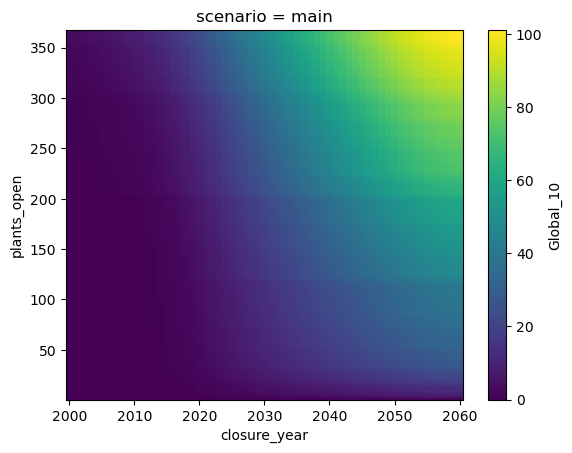

In [395]:
age_ds['Global_10'].sel(scenario = 'main').plot()

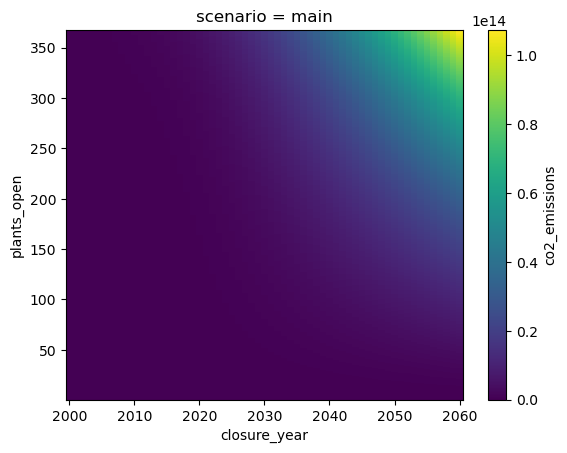

In [398]:
age_ds['co2_emissions'].cumsum().sel(scenario = 'main').plot()

In [419]:
CGP_df.columns

Index(['Unnamed:_0', 'UNITID', 'UNIT', 'PLANT', 'COMPANY', 'MW', 'STATUS',
       'Year_of_Commission', 'UTYPE', 'FUEL', 'FUELTYPE', 'ALTFUEL', 'SSSMFR',
       'BOILTYPE', 'TURBMFR', 'TURBTYPE', 'GENMFR', 'GENTYPE', 'SFLOW',
       'SPRESS', 'STYPE', 'STEMP', 'REHEAT1', 'REHEAT2', 'PARTCTL', 'PART.BAT',
       'PARTMFR', 'SO2CTL', 'SO2.BAT', 'FGDMFR', 'NOXCTL', 'NOX.BAT', 'NOXMFR',
       'AE', 'AE.COUNTRY', 'AE.CHINA', 'CONSTRUCT', 'CON.COUNTRY', 'CON.CHINA',
       'COOL', 'RETIRE', 'CITY', 'STATE', 'COUNTRY', 'AREA', 'SUBREGION',
       'POSTCODE', 'PARENT', 'PAR.COUNTRY', 'PAR.CHINA', 'ELECTYPE', 'BUSTYPE',
       'COMPID', 'LOCATIONID', 'HEATRATE.UNADJ', 'EMISFACTOR.PLATTS',
       'CAPFACTOR', 'ANNUALCO2', 'EMISFACTOR.GCPT', 'HEATRATE.ADJ', 'COAL',
       'EMISFACTOR.CO2', 'HEATRATE', 'EMISFACTOR.BC.GAINS',
       'EMISFACTOR.BC.GAINS.g_mwh', 'MWh_daily', 'BC_(g/day)', 'unique_ID'],
      dtype='object')

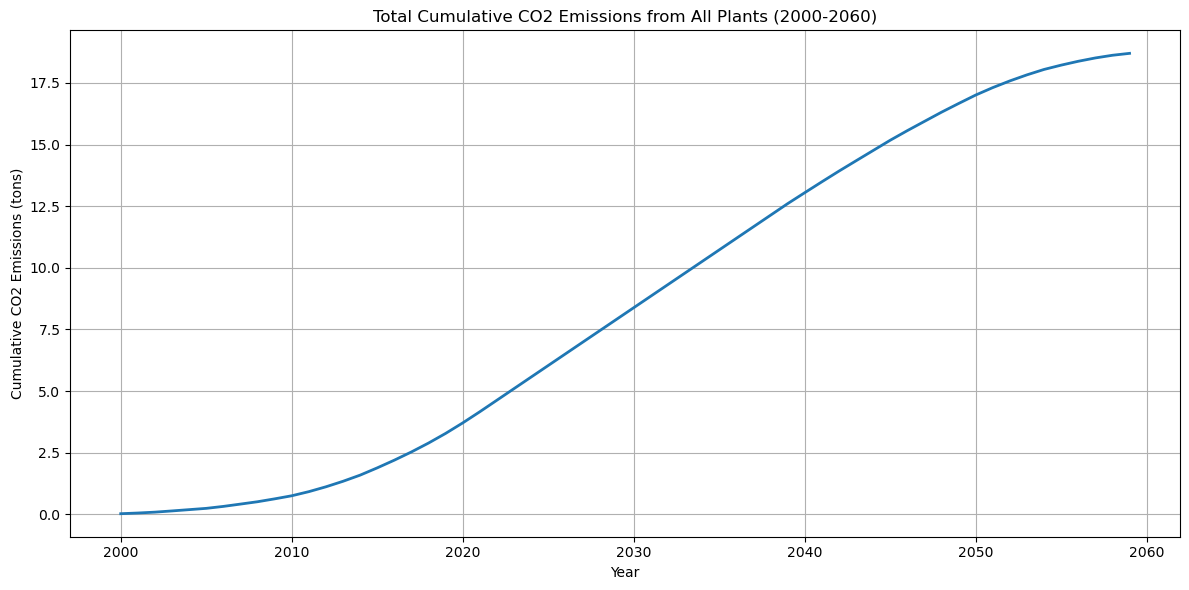

In [26]:
# Set up time array from 2000 to 2060
start_year = 2000
end_year = 2060
years = end_year - start_year
length_simulation = years * 365
time_array = np.arange(0, length_simulation)

# Calculate total CO2 emissions over time
total_emissions = np.zeros(length_simulation)
for unique_id in CGP_df['unique_ID'].values:
    # Get plant data
    plant_data = CGP_df.loc[CGP_df['unique_ID'] == unique_id]
    
    # Calculate annual CO2 emissions (in tons)
    annual_co2 = plant_data['ANNUALCO2']/1e9
    
    # Convert to daily emissions
    daily_co2 = annual_co2 / 365  # tons per day
    
    # Add to total emissions
    yr_offset = (plant_data['Year_of_Commission'].iloc[0] - start_year)
    if yr_offset >= 0:  # Only include plants commissioned after 2000
        test_array = np.where((time_array <= (yr_offset + 40)*365) & (time_array >= yr_offset * 365), True, False)
        total_emissions += test_array * daily_co2.values[0]

# Convert daily emissions to yearly and take cumulative sum
yearly_emissions = total_emissions.reshape(years, 365).sum(axis=1)
cumulative_emissions = np.cumsum(yearly_emissions)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(np.arange(start_year, end_year), cumulative_emissions, linewidth=2)

plt.xlabel('Year')
plt.ylabel('Cumulative CO2 Emissions (tons)')
plt.title('Total Cumulative CO2 Emissions from All Plants (2000-2060)')
plt.grid(True)
plt.tight_layout()
plt.show()

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:525: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_co2 = float(plant_data['ANNUALCO2']) / 1e9  # Convert to GtCO2 and ensure scalar


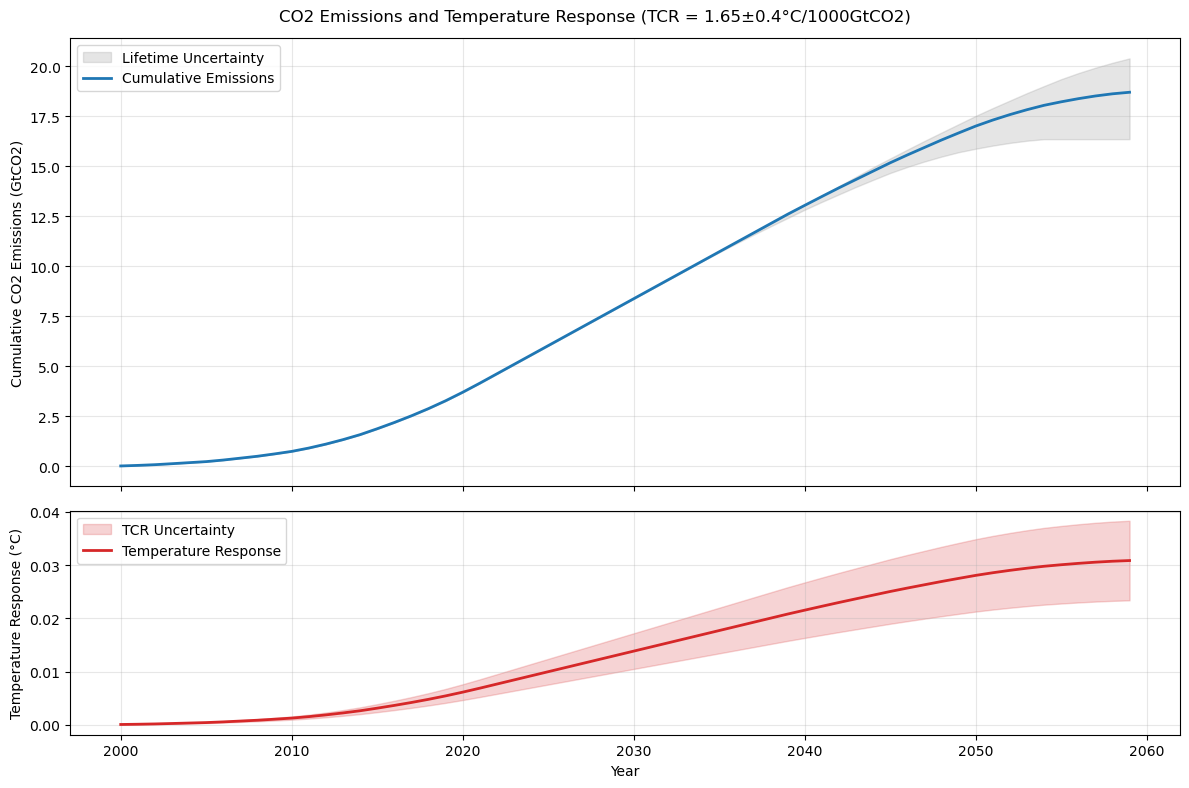

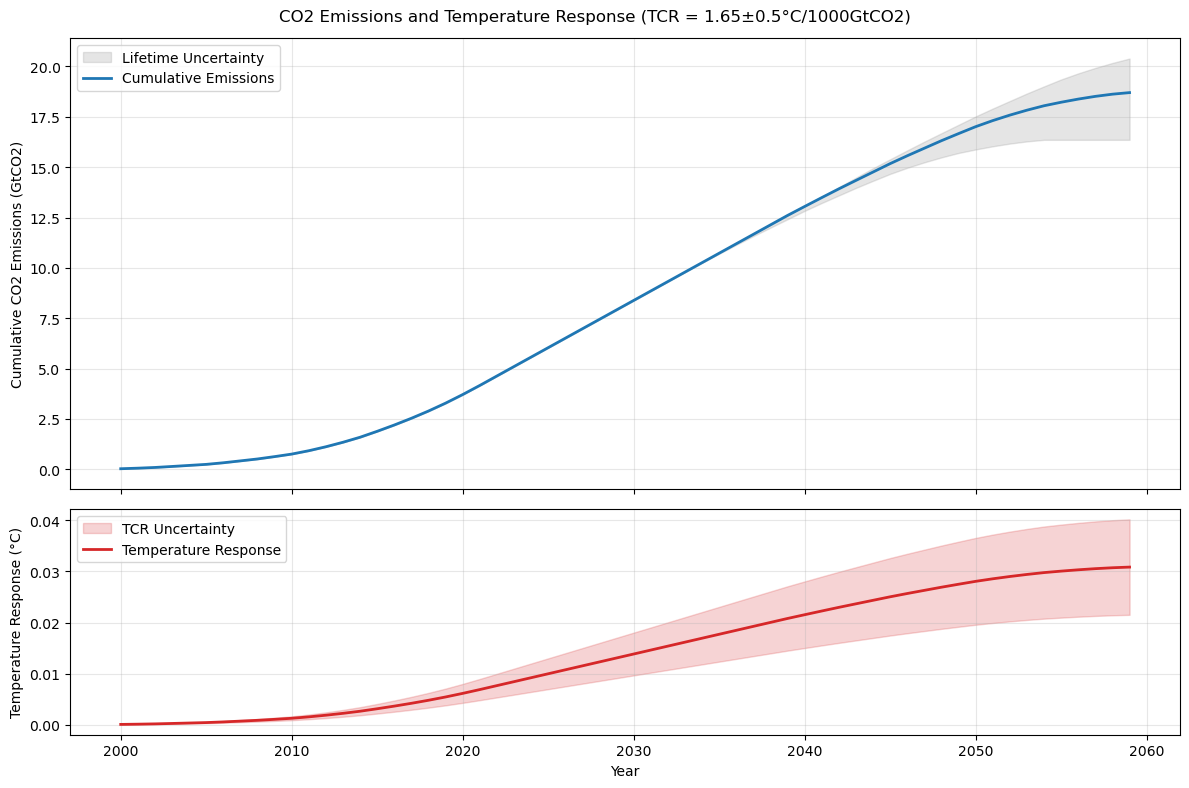

In [24]:
# Basic plot
emissions, temp = plotting_utils.plot_emissions_and_temperature(CGP_df)

# With TCR uncertainty
emissions, temp = plotting_utils.plot_emissions_and_temperature(CGP_df, tcr_uncertainty=0.5)


/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:533: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  # Add emissions for each operating year


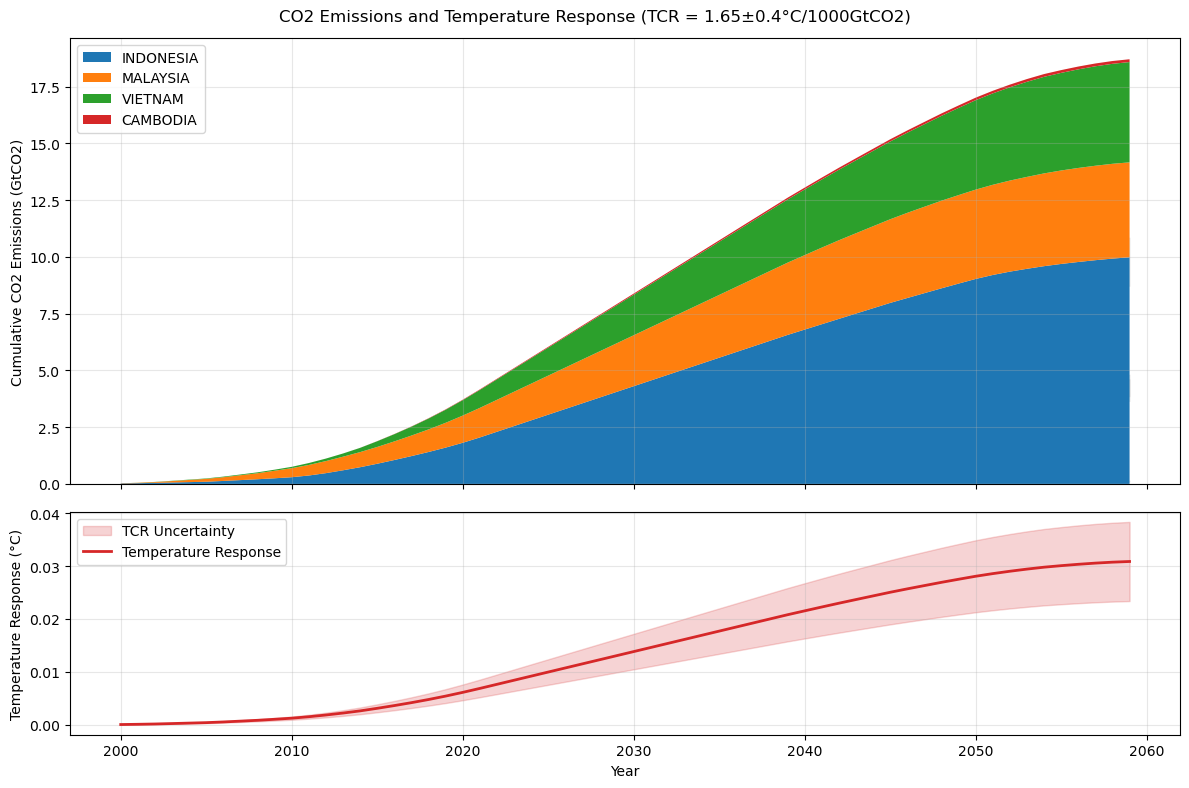

In [31]:

# Breakdown by country
emissions, temp = plotting_utils.plot_emissions_and_temperature(CGP_df, breakdown_by='country')

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:519: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  annual_co2 = float(plant_data['ANNUALCO2']) / 1e9  # Convert to GtCO2 and ensure scalar


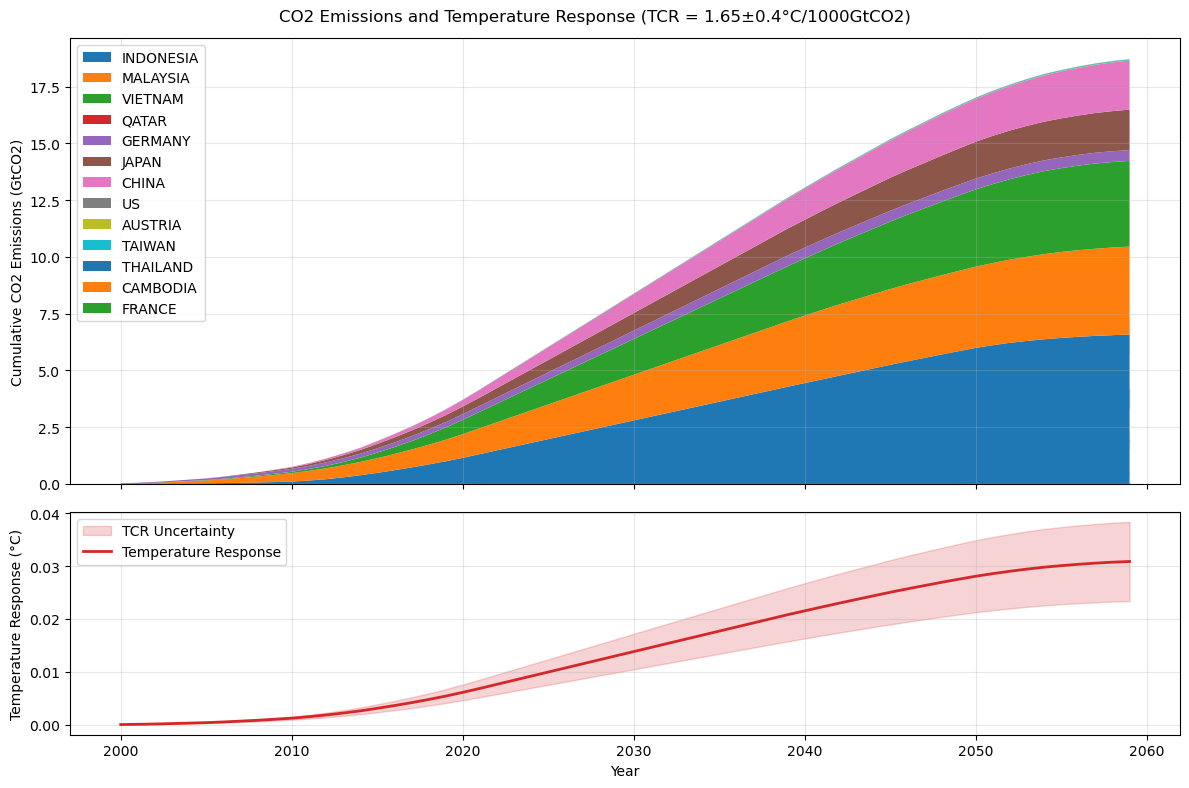

In [40]:


# Breakdown by plant type
emissions, temp = plotting_utils.plot_emissions_and_temperature(CGP_df, breakdown_by='PAR.COUNTRY')

In [31]:
CGP_df['BC_(g/yr)'].sum()*40/1e10

np.float64(2.1639997782470886)

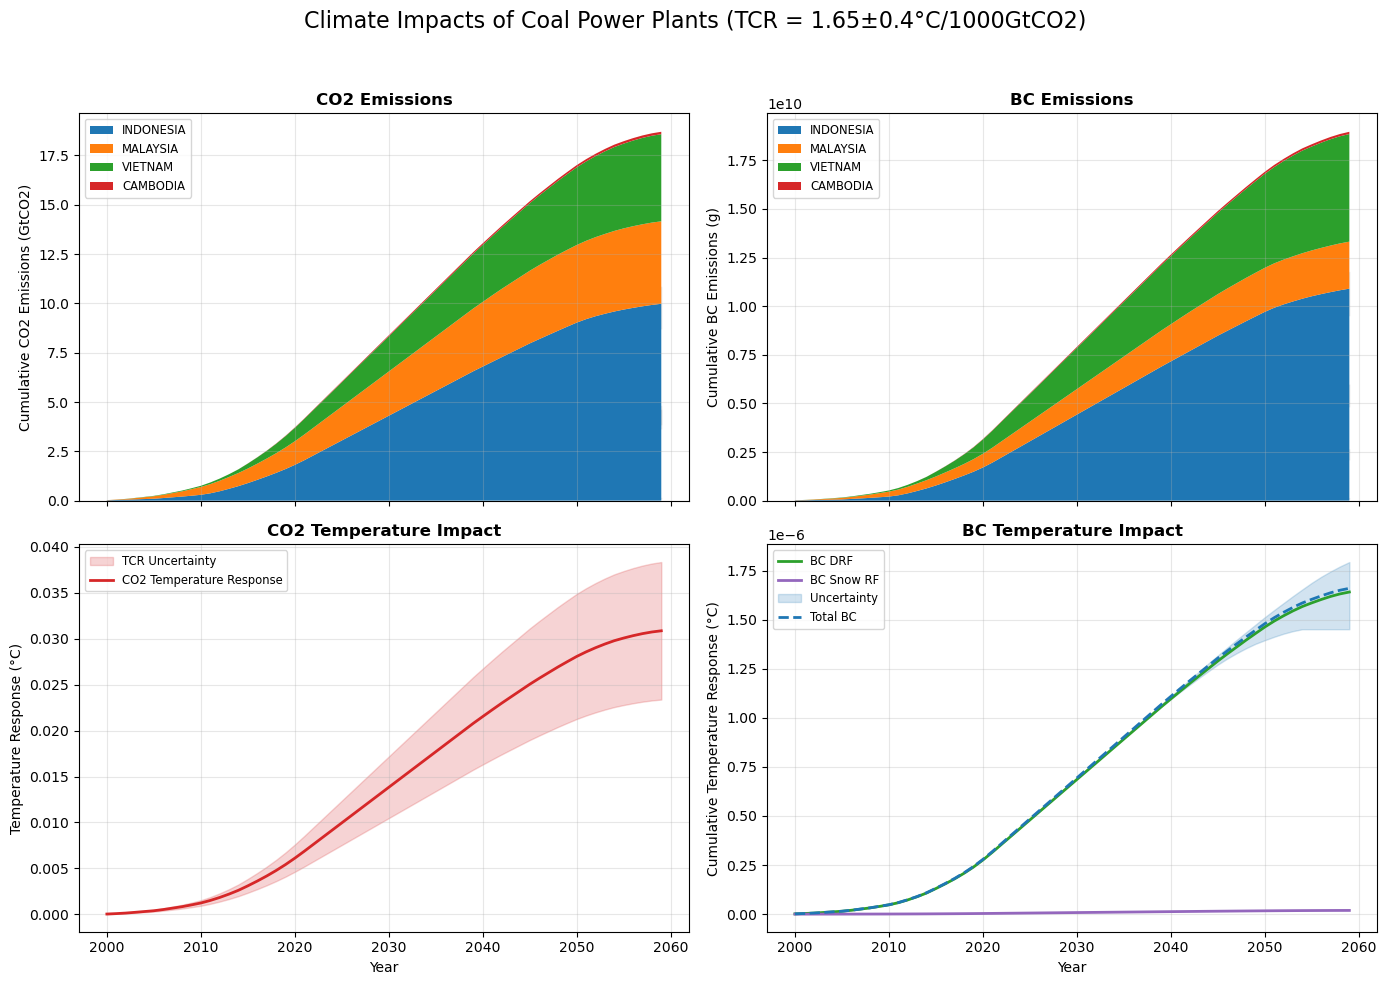

In [33]:
cumulative_emissions, co2_temp_response, cumulative_bc_emissions, cumulative_dt_drf, cumulative_dt_snowrf, total_bc_temp_response, total_temp_response = plotting_utils.plot_emissions_and_temperature_with_bc(
    CGP_df, 
    breakdown_by='COUNTRY'
)

/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:732: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min_operating_years = int(max(0, operating_years - lifetime_uncertainty))
/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:733: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  max_operating_years = int(min(operating_years + lifetime_uncertainty,
/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:734: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  end_year - plant_data['Year_of_Commission'].iloc[0]))
/net/fs11/d0/emfreese/BC-IRF/analysis_plotting/plotting_utils.py:735: FutureWarning: Calling float on a single element Series is deprecated and will raise a 

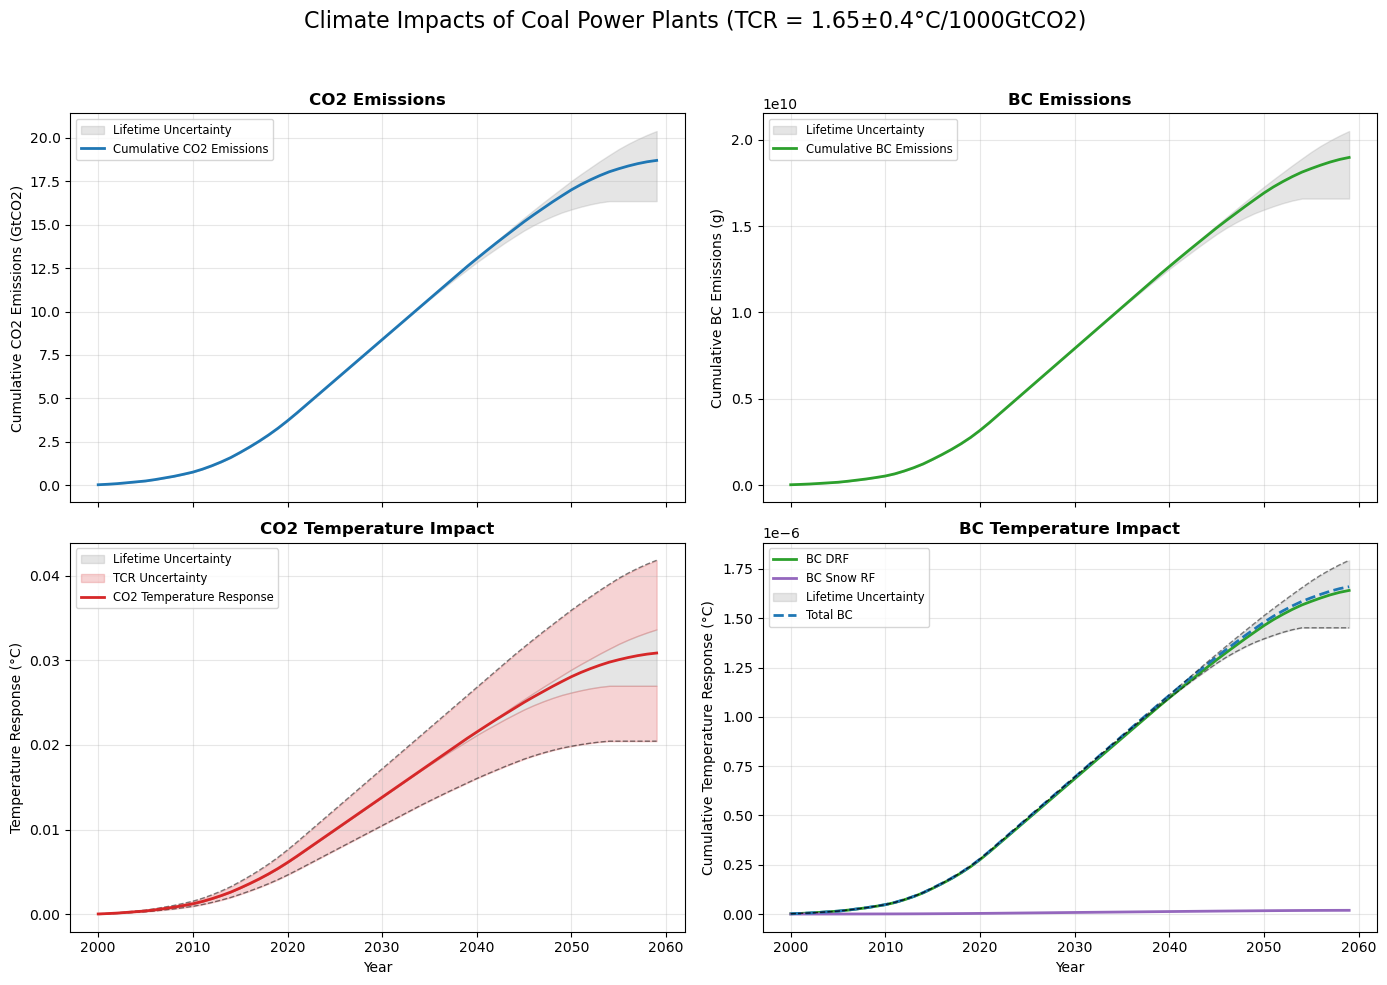

In [46]:
cumulative_emissions, co2_temp_response, cumulative_bc_emissions, cumulative_dt_drf, cumulative_dt_snowrf, total_bc_temp_response, total_temp_response = plotting_utils.plot_emissions_and_temperature_with_bc(
    CGP_df)